In [37]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial
import datetime
from scipy import sparse

from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils

In [2]:
num_processors = cpu_count()
print(num_processors)

today = datetime.datetime.today().strftime('%d-%m-%Y')
output_figures = '/cndd2/fangming/projects/scf_enhancers/results/figures/simulation_{{}}_{}.pdf'.format(today)
output_figures

40


'/cndd2/fangming/projects/scf_enhancers/results/figures/simulation_{}_09-07-2020.pdf'

In [3]:
today

'09-07-2020'

# Todos
- my simulation has no noise.


In [4]:
def shuff_spearmanr_paired_rows_fast(jshuff, X, Y, shuff_col=True, verbose=False):
    """
    """
    seed = int(time.time()*1e7+jshuff)%100
    if verbose:
        print(jshuff)
    
    m, n = X.shape
    if shuff_col:
        return snmcseq_utils.spearmanr_paired_rows_fast(X[:,np.random.RandomState(seed).permutation(n)], 
                                                        Y)
    else:
        return snmcseq_utils.spearmanr_paired_rows_fast(X[np.random.RandomState(seed).permutation(m),:], 
                                                        Y)
    

In [129]:
# evaluation one
def make_plot_1(
              ax,
              title,
              corrs, 
              corrs_shuff_types_mean, corrs_shuff_genes_mean, 
              sigs_shuff_types, sigs_shuff_genes,
              legend=True,
              ylabel=True,
              xlabel=True,
             ):
    """
    """
    config = {
        'kde': False,
        "hist_kws": {
                    'histtype': 'step', 
    #                 'edgecolor': 'none',
                    'alpha': 1, 
                    'density': True, 
                    },
    }
    num_bins = 50
    bins = np.linspace(0, 1, num_bins)
    sns.distplot(corrs, 
                 bins=bins, ax=ax, label='linked pairs', **config)
    sns.distplot(corrs_shuff_types_mean, 
                 bins=bins, ax=ax, label='shuffled types', **config)
    sns.distplot(corrs_shuff_genes_mean, 
                 bins=bins, ax=ax, label='shuffled genes', **config)
    # sns.distplot(np.ravel(corrs_shuff_types), ax=ax, label='shuffled types', **config)
    # sns.distplot(np.ravel(corrs_shuff_genes), ax=ax, label='shuffled genes', **config)
    if legend:
        ax.legend(bbox_to_anchor=(1,1))
    if ylabel:
        ax.set_ylabel('Density of genes \n(num bins={})'.format(num_bins))
    if xlabel:
        ax.set_xlabel('Spearman corr')
    ax.set_title(title)
    return ax

def make_plot_2(
              ax,
              title,
              corrs, 
              corrs_shuff_types_mean, corrs_shuff_genes_mean, 
              sigs_shuff_types, sigs_shuff_genes,
              legend=True,
              ylabel=True,
             ):
    """
    """
    num_bins = 50
    bins = np.linspace(0, 10, num_bins)
    config = {
        'kde': False,
        "hist_kws": {
                    'histtype': 'bar', 
                    'edgecolor': 'none',
                    'alpha': 1, 
                    'density': False, 
                    },
    }
    sns.distplot((corrs/corrs_shuff_types_mean)[sigs_shuff_types], 
                 bins=bins, ax=ax, label='sig', **config)
    config = {
        'kde': False,
        "hist_kws": {
                    'histtype': 'step', 
    #                 'edgecolor': 'none',
                    'alpha': 1, 
                    'density': False, 
                    },
    }
    sns.distplot(corrs/corrs_shuff_types_mean, 
                 bins=bins, ax=ax, color='black', label='all', **config)
    if legend:
        ax.legend(bbox_to_anchor=(1,1))
    ax.set_xlabel('observed/shuffled (by types)')
    if ylabel:
        ax.set_ylabel('Number of genes in bins\n(n={})'.format(num_bins))
    ax.set_title(title)
    return ax 

def make_plot_3(
              ax,
              title,
              corrs, 
              corrs_shuff_types_mean, corrs_shuff_genes_mean, 
              sigs_shuff_types, sigs_shuff_genes,
              legend=True,
              ylabel=True,
             ):
    """
    """
    num_bins = 50
    bins = np.linspace(0, 10, num_bins)
    config = {
        'kde': False,
        "hist_kws": {
                    'histtype': 'bar', 
                    'edgecolor': 'none',
                    'alpha': 1, 
                    'density': False, 
                    },
    }
    sns.distplot((corrs/corrs_shuff_genes_mean)[sigs_shuff_genes], 
                 bins=bins, ax=ax, label='sig', **config)
    config = {
        'kde': False,
        "hist_kws": {
                    'histtype': 'step', 
    #                 'edgecolor': 'none',
                    'alpha': 1, 
                    'density': False, 
                    },
    }
    sns.distplot(corrs/corrs_shuff_genes_mean, 
                 bins=bins, ax=ax, color='black', label='all', **config)
    if legend:
        ax.legend(bbox_to_anchor=(1,1))
    ax.set_xlabel('observed/shuffled (by types)')
    if ylabel:
        ax.set_ylabel('Number of genes in bins\n(n={})'.format(num_bins))
    ax.set_title(title)
    return ax 

In [6]:
def corr_and_call_sig(Gnorm_kn, Mnorm_kn):
    """
    """
    # get correlation
    corrs, ps = snmcseq_utils.spearmanr_paired_rows(Gnorm_kn, Mnorm_kn)

    nshuff = np.min((num_processors*16,128))
    # shuffled
    np.random.seed(0)
    ti = time.time()
    with Pool(processes = int(num_processors/2)) as p:
        res = p.starmap(shuff_spearmanr_paired_rows_fast, 
                        [(jshuff, Gnorm_kn, Mnorm_kn, True, False) for jshuff in range(nshuff)]
                       )
        corrs_shuff_types = np.vstack(res)

        res = p.starmap(shuff_spearmanr_paired_rows_fast, 
                        [(jshuff, Gnorm_kn, Mnorm_kn, False, False) for jshuff in range(nshuff)]
                       )
        corrs_shuff_genes = np.vstack(res)
#     print(time.time()-ti) 
    
    # evaluation - num. sig according to either null distribution
    alpha = 0.01

    # max (sig. threshold), mean (average)
    corrs_shuff_types_max = np.percentile(np.abs(corrs_shuff_types), 1-alpha, axis=0)
    corrs_shuff_types_mean = np.mean(np.abs(corrs_shuff_types), axis=0)
    sigs_shuff_types = corrs_shuff_types_max < corrs
    fdr_shuff_types = alpha*K/sigs_shuff_types.sum()

    # max (sig. threshold), mean (average)
    corrs_shuff_genes_max = np.percentile(np.abs(corrs_shuff_genes), 1-alpha, axis=0)
    corrs_shuff_genes_mean = np.mean(np.abs(corrs_shuff_genes), axis=0)
    sigs_shuff_genes = corrs_shuff_genes_max < corrs
    fdr_shuff_genes = alpha*K/sigs_shuff_genes.sum()

#     print(sigs_shuff_types.sum(), fdr_shuff_types, 
#           sigs_shuff_genes.sum(), fdr_shuff_genes, 
#          )
    
    return (corrs, 
            corrs_shuff_types, corrs_shuff_genes,
            corrs_shuff_types_mean, corrs_shuff_genes_mean,
            sigs_shuff_types, sigs_shuff_genes,
           )

In [55]:
# set up 
def simulate(N, K, I, J, base_lambda=1000, mc_cov=20):
    """
    Enhancer signals are independent
    
    N = 50 # num cell types
    K = 3000 # num genes
    I = 10 # num common TFs
    J = 1 # num private TFs
    
    L = I+JN # total number of TFs
    
    base_lambda = 1000 # baseline expression level of TF
    mc_cov = 20 # baseline methylation coverage
    """
    # common and private TFs
    Cin = np.random.poisson(base_lambda, size=(I, N)) 
    
    # private TFs
    Pjn_lambda = np.repeat(np.eye(N)*base_lambda + np.ones(N)*0.01*base_lambda, J, axis=0)
    Pjn = np.random.poisson(np.random.gamma(Pjn_lambda)) 
    
    # combine
    TFln = np.vstack([Cin, Pjn])
    
    # select 1 TF for each gene (consistently across all cell types)
    # l->k
    TF_select_k = np.random.randint(I+J*N, size=(K))
    TF_ctrl_kn = TFln[TF_select_k,:]
    
#     print(TF_select_k.shape, TF_ctrl_kn.shape)
#     print(Cin.shape, Pjn.shape, TFln.shape,
#           TF_select_k.shape, TF_ctrl_kn.shape
#          )

    # enhancers
    Ekn = np.random.beta(0.5, 0.5, size=(K, N))
    Mkn = np.random.binomial(mc_cov, Ekn)

    # gene expression determined by enhancers and selected TFs
    Gkn = np.random.poisson(TF_ctrl_kn*Ekn)
    
#     print(Ekn.shape, Gkn.shape)
    return Gkn, Mkn 



def simulate2(N, K, I, J, base_lambda=1000, mc_cov=20):
    """
    Enhancer signals are the same 
    if the genes they control are controlled by the same TFs
    
    N = 50 # num cell types
    K = 3000 # num genes
    I = 10 # num common TFs
    J = 1 # num private TFs
    
    L = I+JN # total number of TFs
    
    base_lambda = 1000 # baseline expression level of TF
    mc_cov = 20 # baseline methylation coverage
    """
    # common and private TFs
    Cin = np.random.poisson(base_lambda, size=(I, N)) 
    
    # private TFs
    Pjn_lambda = np.repeat(np.eye(N)*base_lambda + np.ones(N)*0.01*base_lambda, J, axis=0)
    Pjn = np.random.poisson(np.random.gamma(Pjn_lambda)) 
    
    # combine
    TFln = np.vstack([Cin, Pjn])
    
    # select 1 TF for each gene (consistently across all cell types)
    # l->k
    TF_select_k = np.random.randint(I+J*N, size=(K))
    TF_ctrl_kn = TFln[TF_select_k,:]
    
#     print(TF_select_k.shape, TF_ctrl_kn.shape)
#     print(Cin.shape, Pjn.shape, TFln.shape,
#           TF_select_k.shape, TF_ctrl_kn.shape
#          )

    # enhancers
#     Ekn = np.random.beta(0.5, 0.5, size=(K, N))

    # one pattern for each TF
    Eln = np.random.beta(0.5, 0.5, size=(I+J*N, N))
    # same if they belong to the same TFs
    Ekn = Eln[TF_select_k,:] 


    Mkn = np.random.binomial(mc_cov, Ekn)

    # gene expression determined by enhancers and selected TFs
    Gkn = np.random.poisson(TF_ctrl_kn*Ekn)
    
#     print(Ekn.shape, Gkn.shape)
    return Gkn, Mkn 


def simulate3(N, K, M, I, J, X, base_lambda=1000,):
    """
    Enhancer signals are the same 
    if the genes they control are controlled by the same TFs
    
    N = 50 # num cell types
    K = 3000 # num genes
    M = 100,000 # num enhancers
    I = 10 # num common TFs
    J = 1 # num private TFs
    X = 3 # ~ num enhancers per gene
    
    L = I+JN # total number of TFs
    
    base_lambda = 1000 # baseline expression level of TF
    mc_cov = 20 # baseline methylation coverage
    """
    # common and private TFs
    Cin = np.random.poisson(base_lambda, size=(I, N)) 
    
    # private TFs
    Pjn_lambda = np.repeat(np.eye(N)*base_lambda + np.ones(N)*0.01*base_lambda, J, axis=0)
    Pjn = np.random.poisson(np.random.gamma(Pjn_lambda)) 
    
    # combine - TF activity levels
    TFln = np.vstack([Cin, Pjn])
    
    # select 1 TF for each enhancer (consistently across all cell types)
    # l->m
    TF_select_m = np.random.randint(I+J*N, size=(M))
    TF_ctrl_mn = TFln[TF_select_m,:]
    
    # wiring - which enhancer linked to which gene
    Wmk = sparse.random(M, K, density=(K*X/(M*K)), )
    Wmk.data[:] = 1
    
#     print(TF_select_k.shape, TF_ctrl_kn.shape)
#     print(Cin.shape, Pjn.shape, TFln.shape,
#           TF_select_k.shape, TF_ctrl_kn.shape
#          )

    # one pattern for each TF
    Emn = TF_ctrl_mn
#     Mkn = np.random.binomial(mc_cov, Ekn)

    # gene expression determined by enhancers and selected TFs
    Gkn = np.random.poisson(Wmk.T.dot(Emn))
    
#     print(Ekn.shape, Gkn.shape)
    return Gkn, Emn, Wmk 


In [57]:
def pipe(N, K, I, J, base_lambda=1000, mc_cov=20, choose_sim="type1"):
    """
    """
    
    # simulate
    if choose_sim == "type1":
        Gkn, Mkn = simulate(N, K, I, J, base_lambda=base_lambda, mc_cov=mc_cov)
    elif choose_sim == "type2":
        Gkn, Mkn = simulate2(N, K, I, J, base_lambda=base_lambda, mc_cov=mc_cov)
    else:
        raise ValueError

    # normalization
    Gnorm_kn = Gkn/np.median(Gkn, axis=0)
    Mnorm_kn = Mkn/mc_cov

    # corrs and sig
    return corr_and_call_sig(Gnorm_kn, Mnorm_kn)

def pipe2(N, K, M, I, J, X, base_lambda=1000,):
    """
    """
    
    # simulate
    Gkn, Emn, Wmk = simulate3(N, K, M, I, J, X, base_lambda=base_lambda)

    # normalization
    Gnorm_kn = Gkn/np.median(Gkn, axis=0)
    Enorm_mn = Emn/np.median(Emn, axis=0)

    # k->a a indexing over all linked enhancer-gene pairs (nonzeros in Wmk)
    # m->a
    m_idx, k_idx = Wmk.nonzero() 
    Gnorm_an = Gnorm_kn[k_idx,:]
    Enorm_an = Enorm_mn[m_idx,:]
    
    # corrs and sig
    return corr_and_call_sig(Gnorm_an, Enorm_an)

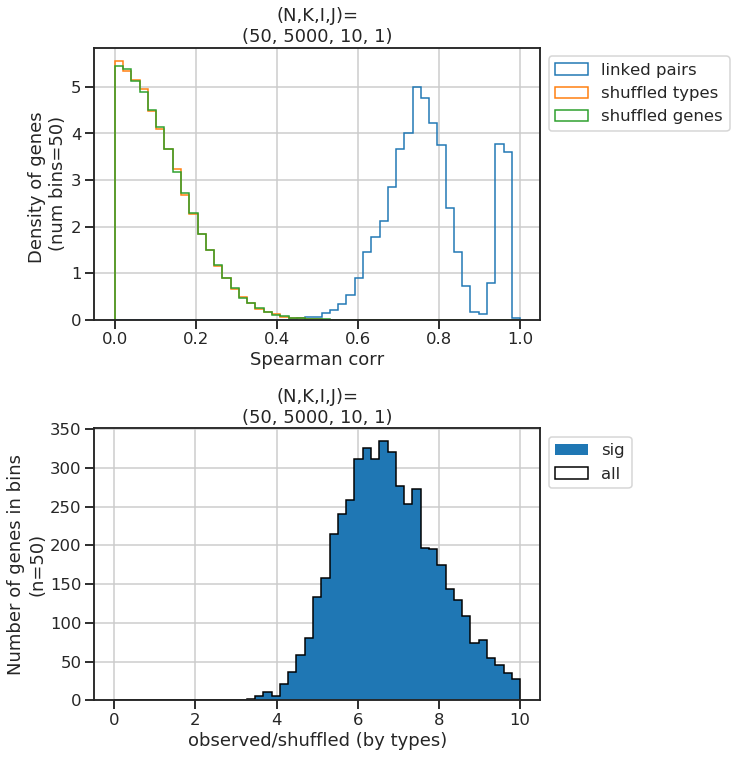

In [31]:
# setup 
N = 50 # num cell types
K = 5000 # num genes
I = 10 # num common TFs
J = 1 # num private TFs
base_lambda = 1000 # baseline expression level of TF
mc_cov = 20 # baseline methylation coverage

choose_sim = 'type1'

# run simulation and evaluation
(corrs, 
 corrs_shuff_types, corrs_shuff_genes,
 corrs_shuff_types_mean, corrs_shuff_genes_mean,
 sigs_shuff_types, sigs_shuff_genes,
) = pipe(N, K, I, J, base_lambda=1000, mc_cov=20, choose_sim=choose_sim)

# make plots
fig, axs = plt.subplots(2, 1, figsize=(8,6*2))
fig.subplots_adjust(hspace=0.4)

make_plot_1(axs[0], 
          N,K,I,J,base_lambda,mc_cov,
          corrs, 
#           corrs_shuff_types_mean, corrs_shuff_genes_mean, 
          np.ravel(corrs_shuff_types), np.ravel(corrs_shuff_genes), 
          sigs_shuff_types, sigs_shuff_genes,
          )
make_plot_2(axs[1], 
          N,K,I,J,base_lambda,mc_cov,
          corrs, 
          corrs_shuff_types_mean, corrs_shuff_genes_mean, 
          sigs_shuff_types, sigs_shuff_genes,
          )

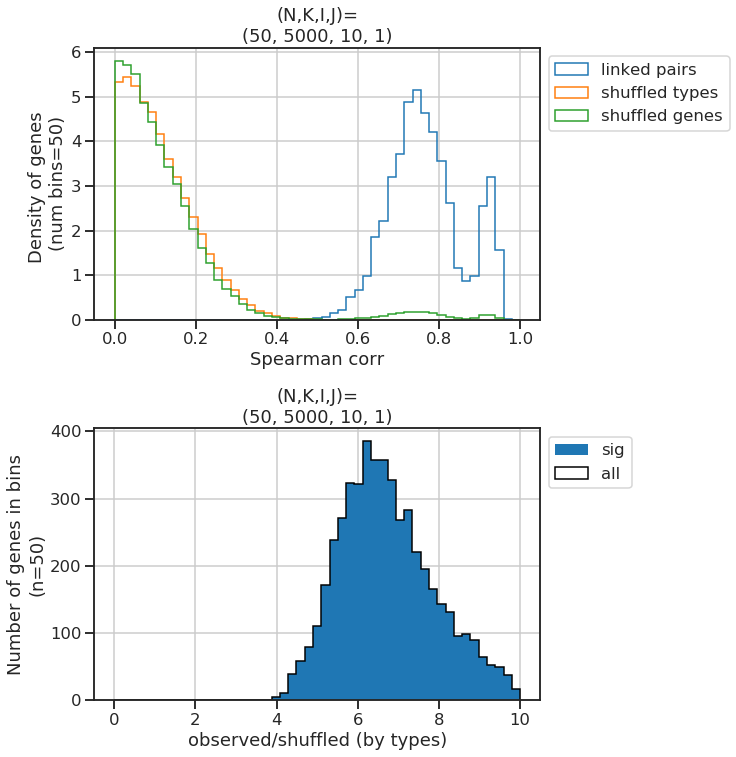

In [32]:
# setup 
N = 50 # num cell types
K = 5000 # num genes
I = 10 # num common TFs
J = 1 # num private TFs
base_lambda = 1000 # baseline expression level of TF
mc_cov = 20 # baseline methylation coverage

choose_sim = 'type2'

# run simulation and evaluation
(corrs, 
 corrs_shuff_types, corrs_shuff_genes,
 corrs_shuff_types_mean, corrs_shuff_genes_mean,
 sigs_shuff_types, sigs_shuff_genes,
) = pipe(N, K, I, J, base_lambda=1000, mc_cov=20, choose_sim=choose_sim)

# make plots
fig, axs = plt.subplots(2, 1, figsize=(8,6*2))
fig.subplots_adjust(hspace=0.4)

make_plot_1(axs[0], 
          N,K,I,J,base_lambda,mc_cov,
          corrs, 
#           corrs_shuff_types_mean, corrs_shuff_genes_mean, 
          np.ravel(corrs_shuff_types), np.ravel(corrs_shuff_genes), 
          sigs_shuff_types, sigs_shuff_genes,
          )
make_plot_2(axs[1], 
          N,K,I,J,base_lambda,mc_cov,
          corrs, 
          corrs_shuff_types_mean, corrs_shuff_genes_mean, 
          sigs_shuff_types, sigs_shuff_genes,
          )

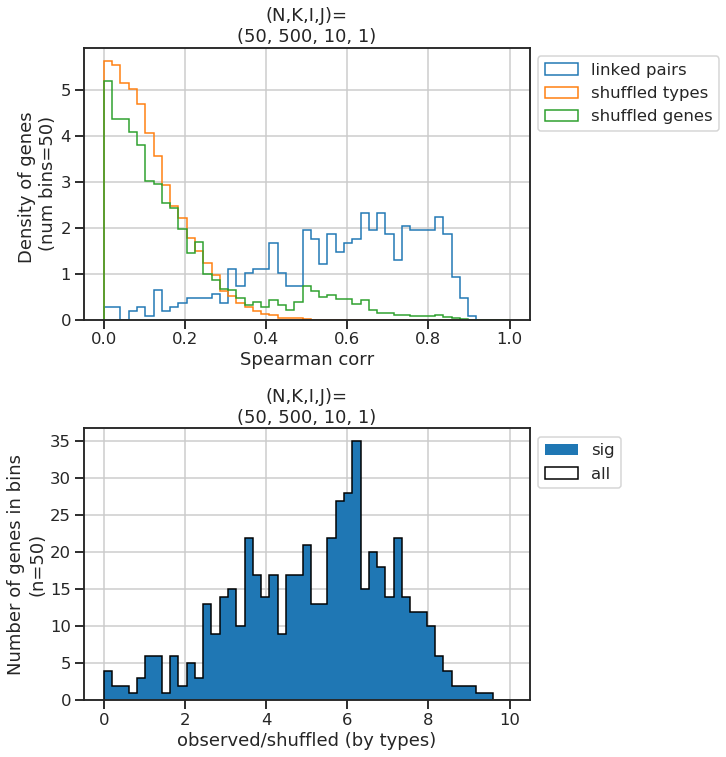

In [63]:
# setup 
N = 50 # num cell types
K = 500 # num genes
M = 5000 # num enhancers
X = 1.1 # num. enhancers per gene
I = 10 # num common TFs
J = 1 # num private TFs

base_lambda = 1000 # baseline expression level of TF
mc_cov = 20 # baseline methylation coverage

choose_sim = 'type3'

# run simulation and evaluation
(corrs, 
 corrs_shuff_types, corrs_shuff_genes,
 corrs_shuff_types_mean, corrs_shuff_genes_mean,
 sigs_shuff_types, sigs_shuff_genes,
) = pipe2(N, K, M, I, J, X, base_lambda=1000,)

# make plots
fig, axs = plt.subplots(2, 1, figsize=(8,6*2))
fig.subplots_adjust(hspace=0.4)

make_plot_1(axs[0], 
          N,K,I,J,base_lambda,mc_cov,
          corrs, 
#           corrs_shuff_types_mean, corrs_shuff_genes_mean, 
          np.ravel(corrs_shuff_types), np.ravel(corrs_shuff_genes), 
          sigs_shuff_types, sigs_shuff_genes,
          )
make_plot_2(axs[1], 
          N,K,I,J,base_lambda,mc_cov,
          corrs, 
          corrs_shuff_types_mean, corrs_shuff_genes_mean, 
          sigs_shuff_types, sigs_shuff_genes,
          )

In [88]:
# N = 50 # num cell types
# K = 5000 # num genes
# I = 10 # num common TFs
# J = 10 # num private TFs

# make the variables the same length! easier for plotting

base_lambda = 1000 # baseline expression level of TF
mc_cov = 2 # baseline methylation coverage
    
N0 = 50
K0 = 5000

X0 = 1.2 # num. enhancers per gene
M0 = 50000 # num enhancers
Ms = [K0, 2*K0, 5*K0, 10*K0,]

I0 = 1
Is = [1, 2, 5, 10, 20, 50, 100]
# Is = [1, 2, 5, 10,]


J0 = 1
Js = [1, 2, 5, 10, 20, 50, 100]
# Js = [1, 2, 5, 10,]

parameter_space = (
    [(N0, K0, M, I0, J0, X0) for M in Ms] + 
    [(N0, K0, M0, I, J0, X0) for I in Is] + 
    [(N0, K0, M0, I0, J, X0) for J in Js] 
)

In [89]:
parameter_space

[(50, 5000, 5000, 1, 1, 1.2),
 (50, 5000, 10000, 1, 1, 1.2),
 (50, 5000, 25000, 1, 1, 1.2),
 (50, 5000, 50000, 1, 1, 1.2),
 (50, 5000, 50000, 1, 1, 1.2),
 (50, 5000, 50000, 2, 1, 1.2),
 (50, 5000, 50000, 5, 1, 1.2),
 (50, 5000, 50000, 10, 1, 1.2),
 (50, 5000, 50000, 20, 1, 1.2),
 (50, 5000, 50000, 50, 1, 1.2),
 (50, 5000, 50000, 100, 1, 1.2),
 (50, 5000, 50000, 1, 1, 1.2),
 (50, 5000, 50000, 1, 2, 1.2),
 (50, 5000, 50000, 1, 5, 1.2),
 (50, 5000, 50000, 1, 10, 1.2),
 (50, 5000, 50000, 1, 20, 1.2),
 (50, 5000, 50000, 1, 50, 1.2),
 (50, 5000, 50000, 1, 100, 1.2)]

In [ ]:
# number of cell types

res1 = []

# setup 
for i_iter, (N,K,M,I,J,X) in enumerate(parameter_space):
    print(i_iter)

    # run simulation and evaluation
    (corrs, 
     corrs_shuff_types, corrs_shuff_genes,
     corrs_shuff_types_mean, corrs_shuff_genes_mean,
     sigs_shuff_types, sigs_shuff_genes,
    ) = pipe2(N, K, M, I, J, X, base_lambda=1000,)

    # fillna
    corrs[np.isnan(corrs)] = 0
    
    # res
    res1.append({
        'N': N, 
        'K': K,
        'M': M,
        'I': I,
        'J': J,
        'X': X,
        'corrs': corrs,
        'corrs_shuff_types': corrs_shuff_types, 
        'corrs_shuff_genes': corrs_shuff_genes,
        'corrs_shuff_types_mean': corrs_shuff_types_mean, 
        'corrs_shuff_genes_mean': corrs_shuff_genes_mean, 
        'sigs_shuff_types': sigs_shuff_types, 
        'sigs_shuff_genes': sigs_shuff_genes,
    })

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


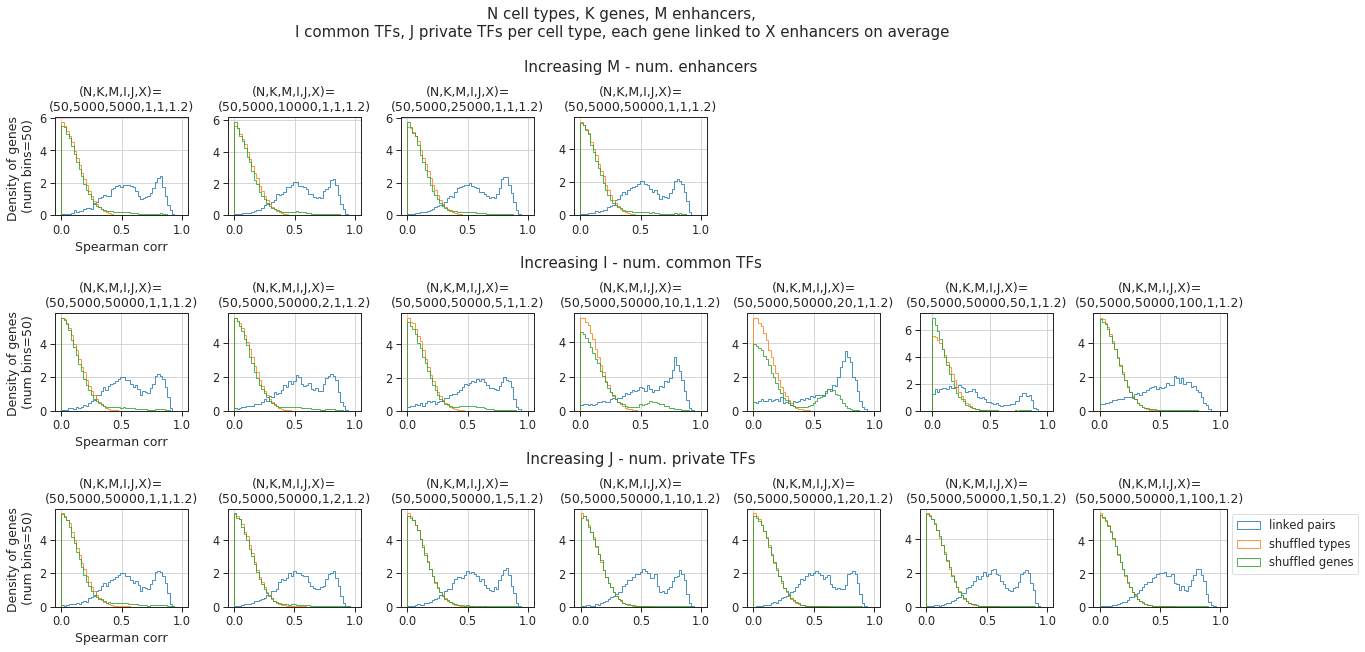

In [132]:
# make plots
nx = max(len(Ms), len(Is), len(Js))
ny = 3
perfig_size=3
# ny = int((len(res1)+nx-1)/nx)

with sns.plotting_context('paper', font_scale=1.3):
    fig, axs = plt.subplots(ny, nx, figsize=(perfig_size*nx,perfig_size*ny))
    fig.subplots_adjust(hspace=1, wspace=0.3)
    fig.suptitle("N cell types, K genes, M enhancers,\n" 
                 "I common TFs, J private TFs per cell type, " 
                 "each gene linked to X enhancers on average", 
                 fontsize=15, y=1.05)
    # axs = axs.flatten()

    i_iter = 0
    for row_idx, (ax_row, paras, row_title) in enumerate(zip(axs, [Ms, Is, Js], 
                                                             [
                                                            'Increasing M - num. enhancers', 
                                                            'Increasing I - num. common TFs', 
                                                            'Increasing J - num. private TFs', 
                                                             ]
                                                            )):
        # add title to each row
        [[xf0, yf0], [xf1, yf1]] = ax_row[0].get_position().get_points()
        [[xl0, yl0], [xl1, yl1]] = ax_row[-1].get_position().get_points()
        big_axs = fig.add_axes([xf0, yf0, xl1-xf0, yl1-yf0])
        big_axs.set_title(row_title, y=1.4, fontsize=15)
        big_axs.axis('off')
        
        for ax in ax_row[len(paras):]:
            ax.axis('off')
        for col_idx, (ax, para) in enumerate(zip(ax_row, paras)):
            res_item = res1[i_iter]

            if col_idx == 0: 
                ylabel = True
                xlabel = True
            else:
                ylabel = False
                xlabel = False

            if i_iter == len(res1)-1:
                legend = True
            else:
                legend = False

            title = "(N,K,M,I,J,X)=\n({},{},{},{},{},{})".format(
                      res_item['N'],res_item['K'],res_item['M'],res_item['I'],res_item['J'],res_item['X'],
                    )
            # make plots
            make_plot_1(ax, 
                      title,
                      res_item['corrs'], 
        #               res_item['corrs_shuff_types_mean'], res_item['corrs_shuff_genes_mean'], 
        #               res_item['corrs_shuff_types'][0], res_item['corrs_shuff_genes'][0], 
                      np.ravel(res_item['corrs_shuff_types']), np.ravel(res_item['corrs_shuff_genes']), 
                      res_item['sigs_shuff_types'], res_item['sigs_shuff_genes'],
                      legend=legend,
                      ylabel=ylabel,
                      xlabel=xlabel,
                      )
            # update i_iter
            i_iter += 1

    output_fig = output_figures.format('model3_NKMIJX_{}_{}_{}_{}.pdf'.format(N0, K0, M0, I0, J0, X0))
    snmcseq_utils.savefig(fig, output_fig)
    plt.show()



## Summary 

In [27]:
res1_df = pd.DataFrame(res1)
# frac sig
res1_df['frac_sig_types'] = res1_df['sigs_shuff_types'].apply(sum)/res1_df['sigs_shuff_types'].apply(len)
res1_df['frac_sig_genes'] = res1_df['sigs_shuff_genes'].apply(sum)/res1_df['sigs_shuff_genes'].apply(len)


# res2_df = pd.DataFrame(res2)
# print(res1_df.shape, res2_df.shape)

(28, 11) (28, 11)


In [28]:

# res2_df['frac_sig_types'] = res2_df['sigs_shuff_types'].apply(sum)/res2_df['sigs_shuff_types'].apply(len)
# res2_df['frac_sig_genes'] = res2_df['sigs_shuff_genes'].apply(sum)/res2_df['sigs_shuff_genes'].apply(len)

# res1_df.head()

,I,J,K,N,corrs,corrs_shuff_genes,corrs_shuff_genes_mean,corrs_shuff_types,corrs_shuff_types_mean,sigs_shuff_genes,sigs_shuff_types,frac_sig_types,frac_sig_genes
0,1,1,5000,5,"[0.29617443888, 0.894427191, -0.210818510678, ...","[[-0.3, 0.6, -0.6, -0.2, 0.3, 0.4, -0.1, -0.6,...","[0.4828125, 0.41328125, 0.41953125, 0.4453125,...","[[0.5, -0.7, -0.1, 0.1, -0.1, 0.0, 0.6, -0.9, ...","[0.37421875, 0.43046875, 0.425, 0.43125, 0.374...","[True, True, False, False, True, True, True, T...","[True, True, False, False, True, True, True, T...",0.7692,0.7710
1,1,1,5000,10,"[0.463724757164, 0.719146519961, -0.0197385508...","[[-0.236363636364, -0.151515151515, -0.1878787...","[0.292045454545, 0.217613636364, 0.28655303030...","[[-0.0424242424242, -0.272727272727, 0.2242424...","[0.234375, 0.294223484848, 0.242992424242, 0.2...","[True, True, False, True, True, True, True, Tr...","[True, True, False, True, True, True, True, Tr...",0.9610,0.9620
2,1,1,5000,20,"[0.508717148573, 0.535133401737, 0.59635543460...","[[-0.106766917293, -0.288721804511, -0.5203007...","[0.185960996241, 0.178042763158, 0.20640272556...","[[-0.269172932331, 0.0556390977444, 0.07518796...","[0.199095394737, 0.224377349624, 0.16300516917...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",0.9986,0.9988
3,1,1,5000,50,"[0.607778512762, 0.644160608929, 0.69062167627...","[[0.210948379352, -0.275678271309, 0.152557022...","[0.127119597839, 0.120366896759, 0.10633478391...","[[0.0883073229292, 0.18962785114, 0.0249219687...","[0.0988107743097, 0.121668667467, 0.1000502701...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",1.0000,1.0000
4,1,1,5000,100,"[0.61189017218, 0.723819534837, 0.628626123627...","[[0.0247704770477, 0.0618661866187, -0.0902850...","[0.0798435156016, 0.0935415729073, 0.075808768...","[[0.100354035404, 0.248388838884, -0.096405640...","[0.0752729335434, 0.09193359961, 0.09511194869...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",1.0000,1.0000


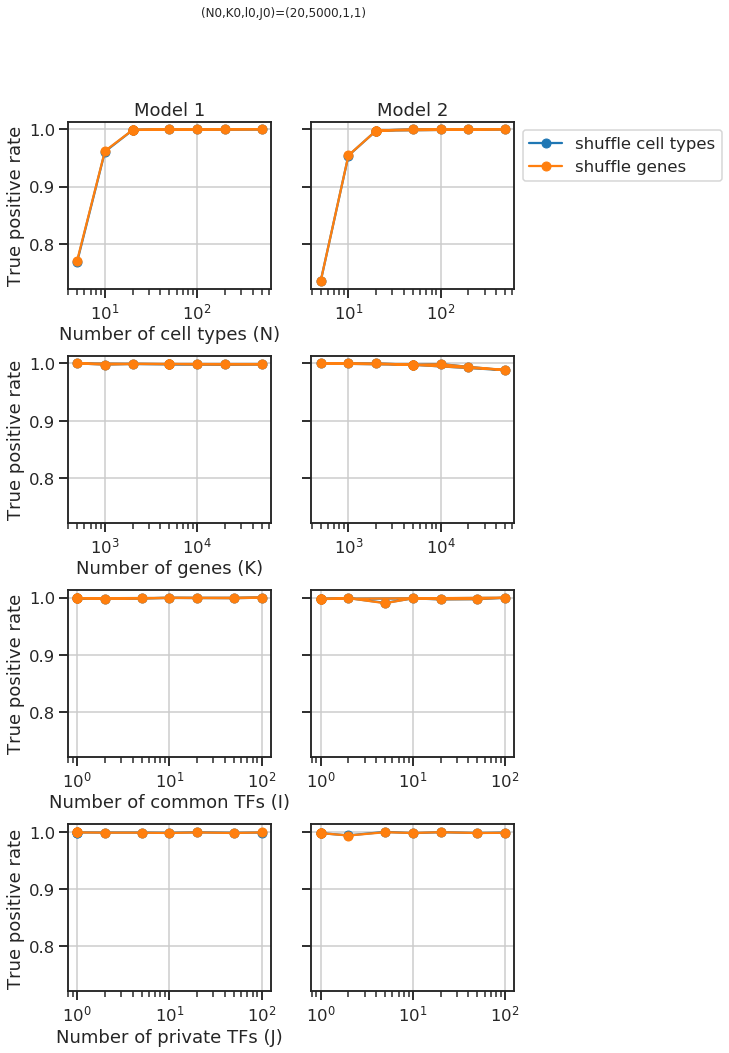

In [29]:
titles = ['Model 1', 
          'Model 2',
         ]
selected_paras = ['N', 'K', 'I', 'J',]
xlabels = ['Number of cell types (N)', 
           'Number of genes (K)',
           'Number of common TFs (I)',
           'Number of private TFs (J)',
          ]
res1_selects = [
 res1_df[((res1_df['I']==I0) & (res1_df['J']==J0) & (res1_df['K']==K0))],
 res1_df[((res1_df['I']==I0) & (res1_df['J']==J0) & (res1_df['N']==N0))],
 res1_df[((res1_df['K']==K0) & (res1_df['J']==J0) & (res1_df['N']==N0))],
 res1_df[((res1_df['K']==K0) & (res1_df['I']==I0) & (res1_df['N']==N0))],
]
res2_selects = [
 res2_df[((res2_df['I']==I0) & (res2_df['J']==J0) & (res2_df['K']==K0))],
 res2_df[((res2_df['I']==I0) & (res2_df['J']==J0) & (res2_df['N']==N0))],
 res2_df[((res2_df['K']==K0) & (res2_df['J']==J0) & (res2_df['N']==N0))],
 res2_df[((res2_df['K']==K0) & (res2_df['I']==I0) & (res2_df['N']==N0))],
]

nparas = len(selected_paras) 

fig, axs = plt.subplots(nparas, 2, sharey=True, figsize=(2*4, nparas*4))
fig.suptitle('(N0,K0,l0,J0)=({},{},{},{})'.format(N0, K0, I0, J0,))
for i, ax_row in enumerate(axs):
    selected_para = selected_paras[i]
    xlabel = xlabels[i]
    res1_select = res1_selects[i]
    res2_select = res2_selects[i]
    
    for j, (ax, res_select, title) in enumerate(
                                zip(ax_row, [res1_select, res2_select], titles)
                                ):
        ax.plot(res_select[selected_para], res_select['frac_sig_types'], '-o', label='shuffle cell types')
        ax.plot(res_select[selected_para], res_select['frac_sig_genes'], '-o', label='shuffle genes')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('True positive rate')
        ax.set_xscale('log')
        if i == 0:
            ax.set_title(title)
        if j == 1: 
            ax.set_xlabel('')
            ax.set_ylabel('')
        if i == 0 and j == 1:
            ax.legend(bbox_to_anchor=(1,1))

fig.subplots_adjust(hspace=0.4)
output_fig = output_figures.format('model_summary_NKIJ_{}_{}_{}_{}.pdf'.format(N0, K0, I0, J0))
snmcseq_utils.savefig(fig, output_fig)
plt.show()